### Second Excersie of Langraph tutorial - LLM with Tools Binding using Router

---

installing core dependencies

In [78]:
%%capture --no-stderr
%pip install -q langchain_google_genai langchain_core langgraph langchain_community

If you're using google colab so load environment in that way

In [ ]:
import os
from google.colab import userdata

os.environ['GOOGLE_API_KEY'] = userdata.get('GEMINI_API_KEY')

if you're working locally so you need to load environment in that way

In [79]:
%%capture --no-stderr
%pip install python-dotenv

create `.env` file in project directory

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()  # Load variables from .env file

os.environ['GOOGLE_API_KEY'] = os.getenv('GOOGLE_API_KEY')

I'm using Gemini Model, so you can use what you like, make sure to install langchain specific package for require Model, and set `API_KEY` accordingly

- Now Initializing Gemini LLM

In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro", temprature=0)

#### Creating Tools for Use with LLMs

In [6]:
# Please add DOCSTRING to the function, so LLM can understand the function
def multiply(a: int, b: int) -> int:
    """
    Multiplies two integers and returns the result.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The product of the two integers.

    Example:
        >>> multiply(3, 4)
        12
        >>> multiply(-2, 5)
        -10
    """
    return a * b


def divide(a: int, b: int) -> float:
    """
    Divides two integers and returns the result.

    Args:
        a (int): The dividend.
        b (int): The divisor.

    Returns:
        float: The quotient of the two integers.

    Example:
        >>> divide(10, 2)
        5.0
        >>> divide(5, 2)
        2.5
    """
    return a / b

Binding this tool with an LLM.

In [7]:
llm_with_tools = llm.bind_tools([multiply, divide])

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


#### Building the Graph with LangGraph

In [25]:
from langgraph.graph.state import StateGraph, CompiledStateGraph, START, END
from langgraph.graph.message import MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage

# if you're just working with messages so use prebuilt `MessagesState` by langgraph, other wise you can create your own state
builder: StateGraph = StateGraph(MessagesState)

creating node for graph

In [26]:
def call_llm(state:MessagesState) -> MessagesState:
    return {'messages': llm_with_tools.invoke(state['messages'])}

While creating the graph, ensure you include your tools using `ToolNode`. Add a conditional edge: if the context is not related to tool calling, the system should move to the end node; otherwise, it will proceed to call the tool.

In [27]:
# Adding Nodes
builder.add_node('call_llm', call_llm)
builder.add_node('tools', ToolNode([multiply, divide]))

# Adding Edges
builder.add_edge(START, 'call_llm')
builder.add_conditional_edges('call_llm', tools_condition)
builder.add_edge('tools', END)

# Compiling the graph
graph: CompiledStateGraph = builder.compile()

##### Displaying the Graph Structure

The following code visualizes the compiled graph using Mermaid PNG

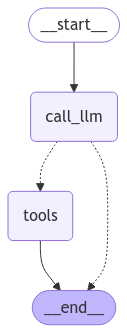

In [28]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

I'm invoking the function without providing the tool-calling context.

In [29]:
result = graph.invoke({'messages':[HumanMessage("Hello World!", name="User")]})

for message in result['messages']:
    message.pretty_print()

================================ Human Message =================================
Name: User

Hello World!
================================== Ai Message ==================================

Hello to you too!


As you can see, no tool was called because the context didn't involve tool invocation.

---

Now, I'll add context for the tool call and observe the result:

In [30]:
result = graph.invoke({'messages':[HumanMessage("What is 5 multiplied by 15?", name="User")]})

for message in result['messages']:
    message.pretty_print()

================================ Human Message =================================
Name: User

What is 5 multiplied by 15?
================================== Ai Message ==================================
Tool Calls:
  multiply (8954bb40-5182-4f6e-8686-951edd7443ab)
 Call ID: 8954bb40-5182-4f6e-8686-951edd7443ab
  Args:
    a: 5.0
    b: 15.0
================================= Tool Message =================================
Name: multiply

75
